# Tutorial 2c - Code Modifications Tutorial (Visualization)

This tutorial is an introduction to analyzing results from your code moficiations for NEON cases.  It uses results from the case you ran in the 0b and 2c tutorials, but you don't have to wait for those runs to complete before doing this tutorial too. We've prestaged model results from this simulation in a shared directory. This way, you can get started on analyzing simulations results before your simulations finish running.

You can also check (NEON visualization)[`https://ncar.github.io/ncar-neon-books/notebooks/NEON_Visualization_Tutorial.html`] tutorial for more advance visualization features. 

## In this tutorial

The tutorial has several objectives: 
1. Increase familiarity with `Xarray` and `pandas`.
2. Increase knowledge of python packages and their utilities
3. Compare results from original code with the modified code for a NEON tower.


***
**This tutorial uses a Jupyter Notebook.** A Jupyter Notebook is an interactive computing environment that enables the creation and sharing of documents that contain discrete cells of text or documentation and executable code, including plots. It allows users to access, run, and edit the code in a browser. To interact with this notebook:

- Execute or "run" cells of executable code (cells denoted with '[ ]:') using the play button in the menu at the top (see below image)

- The results of running code, such as plots, will appear below that cell

- Each step must be followed in order, otherwise you may encounter errors

![run cell](https://problemsolvingwithpython.com/02-Jupyter-Notebooks/images/run_cell.png)

For more information on Jupyter notebooks please see the [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html). 


<div class="alert alert-block alert-info">
<b>NOTE:</b> In Day 2c, executable code blocks used a Bash shell, or had to be executed on the command-line.  In this tutorial, we will be using Python code, and you should directly execute the contents of code blocks by running individual cells in this Jupyter notebook, similar to the Day 0b <i>Run NEON</i> tutorial.
</div>

***

# 1. Load our python packages

Here we are importing python package and libraries we are using for this simulations:

In [68]:
#Import Libraries
%matplotlib inline

import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats

from neon_utils import download_eval_files

In [2]:
neon_site = "KONZ"
year = "2018"

## 2. Load and explore CTSM data:

### 2.1 Load original CTSM results:
Here, we want to read and analyze the result from original (unmodified) CTSM code.
First, let's list all our CTSM files:

In [30]:
sim_path = "/scratch/negins/CLM-NEON/archive/"+neon_site+".transient/lnd/hist"
sim_files = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All simulation files: [", len(sim_files), "files]")
print(*sim_files,sep='\n')

All simulation files: [ 365 files]
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-01-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-02-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-03-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-04-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-05-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-06-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-07-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-08-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-09-00000.nc
/scratch/negins/CLM-NEON/archive/KONZ.transient/lnd/hist/KONZ.tra

Next, let's load read ctsm history files into memory. 

For this purpose, we are using `open_mfdataset` function which opens up multiple netcdf files at the same time. 

In [31]:
start = time.time()
ds_ctsm_orig = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True)
end = time.time()
print("Reading original simulation files took:", end-start, "s.")

Reading original simulation files took: 58.26897430419922 s.


This step looks at the dataset that was just created from the simulation data. This step is not required, but will allow you to explore the python dataset and become familiar with the data.

Run the below cell to find more information about the data:

In [33]:
ds_ctsm_orig

<xarray.Dataset>
Dimensions:       (time: 17520, levgrnd: 25, levsoi: 20, levlak: 10,
                   levdcmp: 25, hist_interval: 2, lndgrid: 1)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:29:59.12...
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/42)
    mcdate        (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds   (time, hist_interval) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    ...            ...
    HR            (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    NET_NMIN_vr   (time, levdcmp, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    SOILC_vr      (time, levsoi, lndgrid) float32 dask.array<chunksize=(96, 20, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/18/22 21:12:47
    source:                               Community Terrestrial Systems Model
    hostname:                             aws-hpc6a
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30

In the output, you can click on Dimensions, Coordinates, Data Variables, and Attributes to expand and see the details and metadata associated with this dataset.

If you click on Data Variables, you will see a list of all the available variables. You can click on the ‘note’ icon at the right end of the line for each variable to see a description of the variable (the long_name) and its units, as well as other information. Here are a few questions to consider:

Questions to consider

1. What variables are available in the dataset?

2. What is the long_name and unit of the variable FSH?

3. Can you find the dimensions of this variable?


<div class="alert alert-block alert-info">

<b>💡 Tip: </b>  Xarray has built-in plotting functions. For quick inspection of a variable, we can use .plot() to see it. Xarray plotting functionality is a thin wrapper around the popular `matplotlib` library. For more advanced plots, we use `matplotlib` directly.

</div>

Let's quickly inspect GPP from original simulation.

<div class="alert alert-block alert-info">

<b>INFO:</b>  Gross Primary Production (GPP) is the total amount of CO2 that is fixed by plants through photosynthesis.

</div>

The code below will make a basic plot of the Gross Primary Production (GPP) variable:

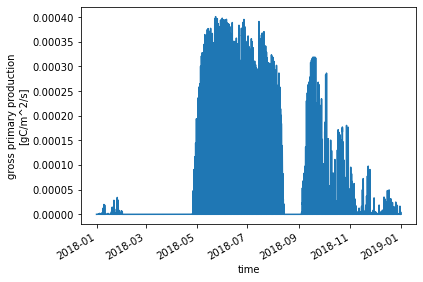

In [93]:
ds_ctsm_orig.GPP.plot()

You can select to plot only specific time period using `.sel` option. 

For example,let's check GPP for June of 2018:

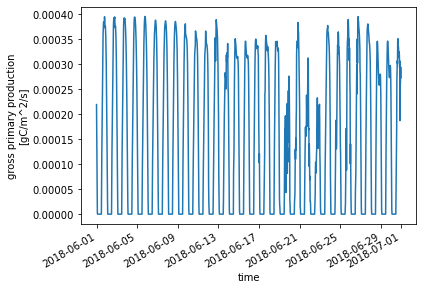

In [50]:
ds_ctsm_orig.GPP.sel(time=slice('2018-06-01', '2018-06-30')).plot()

By now you might have noticed the unit of GPP in the CTSM history output files. 


In [104]:
ds_ctsm_orig.GPP.units

'gC/m^2/s'

Let's change the unit from gC/m-2s-1 to gC/m-2day-1:

In [106]:
ds_ctsm_orig['GPP'] = ds_ctsm_orig['GPP']*60*60*24
ds_ctsm_orig['GPP'].attrs['units'] = 'gC/m^2/day'

Let's remake the plot from above, using the new unit:

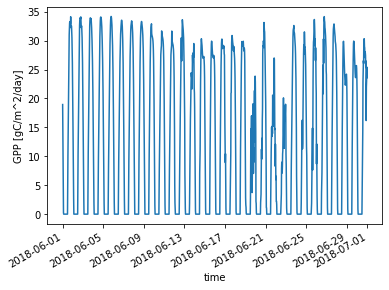

In [108]:
ds_ctsm_orig.GPP.sel(time=slice('2018-06-01', '2018-06-30')).plot()

### 2.2 Load modified CTSM results:

Now, we have to load the result from the modified CTSM code:

In [175]:
sim_path_mod = "/scratch/negins/CLM-NEON-phenologychange/archive/"+neon_site+".transient/lnd/hist"
sim_files_mod = sorted(glob(join(sim_path_mod,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All simulation files from modified simulation: [", len(sim_files_mod), "files]")
print(*sim_files_mod,sep='\n')

All simulation files from modified simulation: [ 365 files]
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-01-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-02-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-03-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-04-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-05-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-06-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-07-00000.nc
/scratch/negins/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-08-00000.nc
/scratch/neg

In [176]:
start = time.time()
ds_ctsm_mod = xr.open_mfdataset(sim_files_mod, decode_times=True, combine='by_coords',parallel=True)
end = time.time()
print("Reading modified simulation files took:", end-start, "s.")

Reading modified simulation files took: 59.546133041381836 s.


Now, let's inspect GPP from the modified simulation:

In [177]:
ds_ctsm_mod

<xarray.Dataset>
Dimensions:       (time: 17520, levgrnd: 25, levsoi: 20, levlak: 10,
                   levdcmp: 25, hist_interval: 2, lndgrid: 1)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:29:59.12...
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/42)
    mcdate        (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds   (time, hist_interval) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    ...            ...
    HR            (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    NET_NMIN_vr   (time, levdcmp, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    SOILC_vr      (time, levsoi, lndgrid) float32 dask.array<chunksize=(96, 20, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/19/22 03:43:07
    source:                               Community Terrestrial Systems Model
    hostname:                             aws-hpc6a
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30

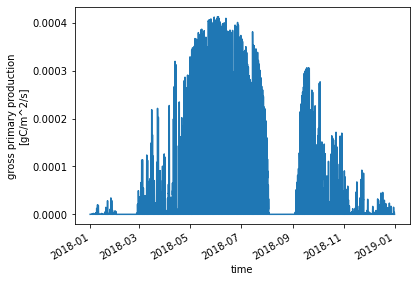

In [178]:
ds_ctsm_mod.GPP.plot()

While loading the original simulations we have changed GPP unit, we should do so here too:

In [179]:
ds_ctsm_mod['GPP'] = ds_ctsm_mod['GPP']*60*60*24
ds_ctsm_mod['GPP'].attrs['units'] = 'gC/m^2/day'

**Question**: Can you noticed how the two simulations are different?

Let's quickly inspect GPP from both simulations for 2018-06:



**Question**: With the skills you learnt so far, can you plot `ELAI` for june 2018?



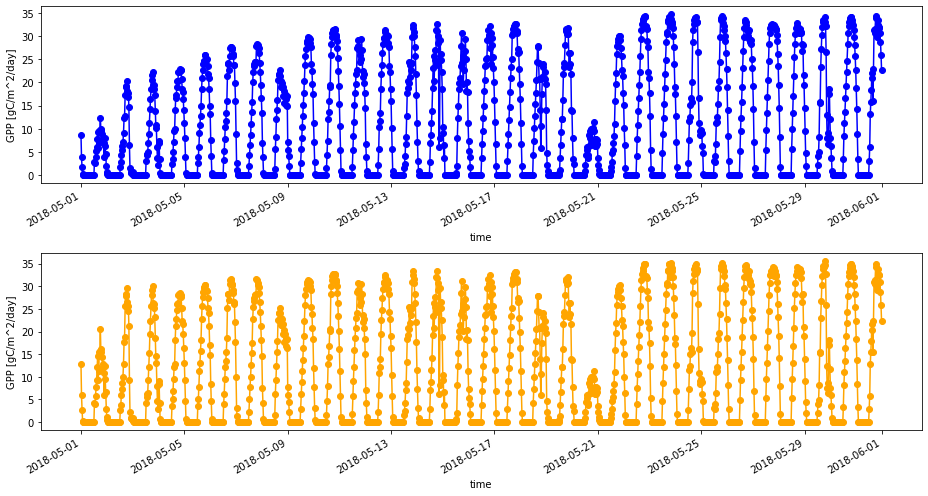

In [180]:
fig, axes = plt.subplots(nrows=2, figsize=(13,7))
ds_ctsm_orig.GPP.sel(time='2018-05').plot(ax=axes[0], color='blue',marker="o")
ds_ctsm_mod.GPP.sel(time='2018-05').plot(ax=axes[1], color='orange',marker="o")
plt.tight_layout(); 

______________________________________________________________

## 3. Explore NEON Tower Observation Data

### 3.1 Download NEON data

<div class="alert alert-block alert-info">

<b>💡 NOTE: </b>  NEON provides some evaluation data for NEON sites from observation at 30 minutes time interval. NEON data for evaluation are pulled from the API and the least restrictive quality control flags are applied. The data are subsequently gap-filled using a redundant data stream regression, while data that are still missing are filled using a Marginal Distribution Sampling (MDS) gap-filling technique. Unit conversions are performed and the data are formatted and supplied as monthly netCDF files.

</div>

To download the data, this step uses a preestablished function (download_eval_files) to download the NEON observational data files for the site and year specified above. The preprocessed NEON data are available for download from NEON’s GCS (Google Cloud Storage) bucket, with the full listing of available data here.

Note that this downloads the evaluation data based on the year you selected above. If you would like to download all available NEON evaluation data from this site, change the word year to "all" (quotes included) below: download_eval_files(neon_site, eval_dir, "all")

Run the cell below to download available NEON data from the site and year you selected above:


In [66]:
eval_dir = "/scratch/negins/evaluation_files/"
download_eval_files(neon_site, eval_dir, year)

Download finished successfully for listing.csv .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-01.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-02.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-03.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-04.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-05.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-06.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-07.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-08.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018-09.nc .
Download finished successfully for /scratch/negins/evaluation_files/KONZ/KONZ_eval_2018

## 3.2 Load NEON data

Now, let's read these downloaded evaluation files from NEON:

In [69]:
eval_path = os.path.join(eval_dir,neon_site)
eval_files = sorted(glob(join(eval_path,neon_site+"_eval_"+year+"*.nc")))

start = time.time()
ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')
end = time.time()
print("Reading all observation files took:", end-start, "s.")

Reading all observation files took: 0.18225908279418945 s.


### 3.3 Inspect NEON data:

Let's inspect the evaluation files from NEON quickly: 

In [70]:
ds_eval

<xarray.Dataset>
Dimensions:          (lat: 1, time: 17520, lon: 1)
Coordinates:
  * lat              (lat) float64 39.1
  * lon              (lon) float64 263.4
  * time             (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:30:00
Data variables: (12/15)
    LATIXY           (time, lat) float64 dask.array<chunksize=(1488, 1), meta=np.ndarray>
    LONGXY           (time, lon) float64 dask.array<chunksize=(1488, 1), meta=np.ndarray>
    NEE              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    FSH              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    EFLX_LH_TOT      (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    GPP              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    ...               ...
    NEE_fqc          (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    FSH_fqc          (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    EFLX_LH_TOT_fqc  (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    GPP_fqc          (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    Ustar_fqc        (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    Rnet_fqc         (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
Attributes:
    created_on:     Mon Nov  1 23:06:47 2021
    created_by:     David Durden
    created_from:   /home/ddurden/eddy/tmp/CLM/KONZ/KONZ_2018-01-01_2021-10-0...
    NEON site:      KONZ
    TimeDiffUtcLt:  -6
    created_with:   flow.api.clm.R
    supported_by:   This data development was funded by the National Science ...

Let's check GPP from NEON files, what is GPP unit from NEON files?

In [96]:
ds_eval.GPP

<xarray.DataArray 'GPP' (time: 17520, lat: 1, lon: 1)>
dask.array<concatenate, shape=(17520, 1, 1), dtype=float64, chunksize=(1488, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 39.1
  * lon      (lon) float64 263.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:30:00
Attributes:
    units:      umolm-2s-1
    long_name:  gross primary productivity
    mode:       time-dependent

Question: Do you remember what the unit of GPP was from CTSM simulation files?

We should convert to unit from NEON files to match the same unit as CTSM files. 

We can convert umolm-2s-1 to gCm-2s-1 by using molecular weight of Carbon:

In [116]:
#-- convert NEE units from  umolm-2s-1 to gc/m2/s
ds_eval['GPP'] = ds_eval['GPP']*(12.01/1000000)

#-- convert from gc/m2/s to gc/m2/day
ds_eval['GPP'] = ds_eval['GPP']*60*60*24
ds_eval['GPP'].attrs['units'] = 'gC/m^2/day'

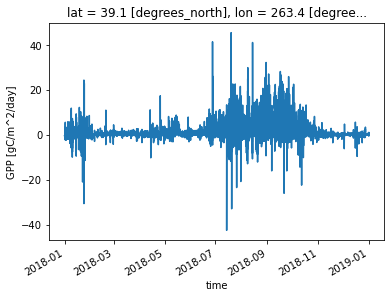

In [117]:
ds_eval.GPP.plot()

Question: Can you tell which one of the simulations is closest to the NEON evaluation files?
___________________________

## 4. Compare CLM and NEON latent heat flux data¶
### 4.1 Format all data
So far, we have loaded files of observational and model (original and modified code) data. In this section we will compare observed and GPP fluxes. You can also explore other available variables with this code.

<div class="alert alert-danger">
  <strong>A note about model timestamps:</strong> 
    
The CTSM history includes an initial 0th timestep for each model simulation. This offset in the time dimension can cause challenges when analyzing and evaluating model data if not treated properly. You may notice in the last line of the below cell, we shift the value by -1 to address this issue. In tutorial 2b, we also handled it using the fix_time function while loading the netCDf files. 
</div>

Run the following cells of code to extract the variables needed for this notebook and create a single dataframe that includes all the extracted variables:

In [132]:
#Convert NEON data to a Pandas Dataframe for easier handling:
#-- fields to extract
eval_vars = ['GPP','NEE']

df_all = pd.DataFrame({'time':ds_eval.time})

for var in eval_vars:
    field = np.ravel ( ds_eval[var])     
    df_all[var]=field

We can inspect the dataframe created quickly:

In [133]:
df_all.head()

,time,GPP,NEE
0,2018-01-01 00:00:00,-0.305005,0.532182
1,2018-01-01 00:30:00,-0.238410,0.459569
2,2018-01-01 01:00:00,-0.381606,0.583214
3,2018-01-01 01:30:00,-0.352932,0.548177
4,2018-01-01 02:00:00,-0.409851,0.593901


In [136]:
#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = ['GPP','AR','HR','ELAI']
df_ctsm = pd.DataFrame({'time':ds_ctsm_orig.time})

for var in ctsm_vars:
    sim_var_name = "sim_"+var+"_orig"
    df_all[sim_var_name]=np.ravel(ds_ctsm_orig[var]) 
    df_all[sim_var_name]=df_all[sim_var_name].shift(-1).values

    sim_var_name = "sim_"+var+"_mod"
    df_all[sim_var_name] = np.ravel(ds_ctsm_mod[var])
    df_all[sim_var_name]=df_all[sim_var_name].shift(-1).values

### 4.2 [Optional] Extract and save your data in `.csv` format:

If you are unfamiliar with reading and using the netcdf file format that model and evaluation data are provided, you can save data different formats. The next cell of code will save the pre-processed data in .csv, or comma-seperated file format.

In [140]:
csv_dir = "~/preprocessed_data/"

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.mkdir(csv_dir)

csv_out = os.path.join(csv_dir, "preprocessed_"+neon_site+"_"+year+".csv")
df_all.to_csv(csv_out,index=False)

### 4.3 Plotting GPP Time Series (Daily Average):

This creates a time-series plot comparing daily average latent heat flux from observations (NEON) and simulations (CLM). To start, we need calculate the daily averages. Run the below cells of code to create the averages and plot.

First, we need to extract year, month, day and hour from time column

In [144]:
#-- extract year, month, day, hour information from time
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour

Next, calculate daily average:

In [146]:
df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])


Using the daily averages, we will create a plot using Python’s [matplotlib package](https://matplotlib.org/).

Run the below cell to create the plot:

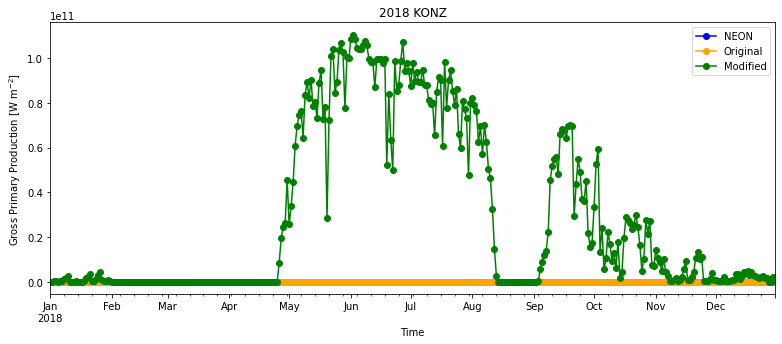

In [154]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = 'GPP' , marker = 'o' ,ax =ax , color = 'b',label="NEON")
df_daily.plot ( x= 'time', y = "sim_GPP_orig" , marker = 'o' ,ax =ax , color = 'orange',label="Original")
df_daily.plot ( x= 'time', y = "sim_GPP_mod" , marker = 'o' ,ax =ax , color = 'g',label="Modified")

plt.xlabel('Time')
plt.ylabel("Gross Primary Production [W m$^{-2}$]")
plt.title(year+" "+neon_site)
plt.show()

Are the simulations and observations in the plot similar?¶

Can you explain how changing the `rain_threshhold` for leaf onset caused the difference?

It is important to also look at variability, as this gives us an indication of when and where simulations are outside the range of observed values.

Let’s explore variability by adding the daily standard deviation as a shaded area to the plot:





In [156]:
df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])

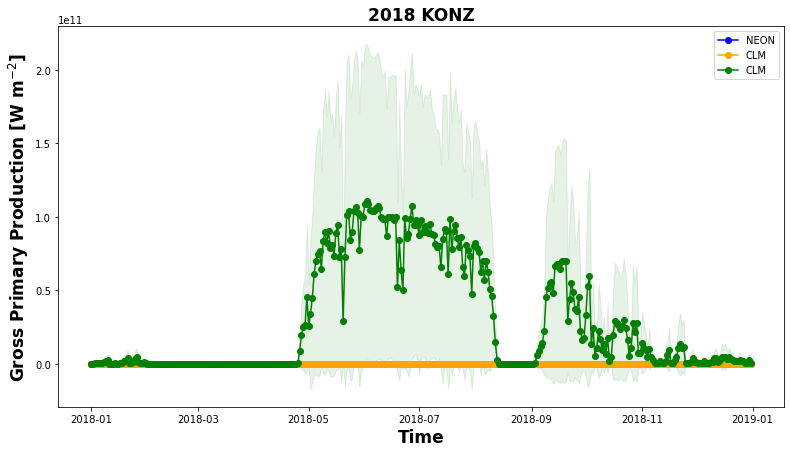

In [165]:
plt.figure(num=None, figsize=(13, 7),  facecolor='w', edgecolor='k')

plt.plot ( df_daily.time, df_daily['GPP'], marker = 'o' , color = 'b',label="NEON")
plt.plot ( df_daily.time, df_daily['sim_GPP_orig'], marker = 'o' , color = 'orange',label="CLM")
plt.plot ( df_daily.time, df_daily['sim_GPP_mod'], marker = 'o' , color = 'g',label="CLM")

plt.fill_between(df_daily.time, df_daily['GPP']-df_daily_std['GPP'], df_daily['GPP']+df_daily_std['GPP'] ,alpha=0.1, color = 'b')
plt.fill_between(df_daily.time, df_daily['sim_GPP_orig']-df_daily_std['sim_GPP_orig'], df_daily['sim_GPP_orig']+df_daily_std['sim_GPP_orig'] ,alpha=0.1, color = 'orange')
plt.fill_between(df_daily.time, df_daily['sim_GPP_mod']-df_daily_std['sim_GPP_mod'], df_daily['sim_GPP_mod']+df_daily_std['sim_GPP_mod'] ,alpha=0.1, color = 'g')

plt.legend()
plt.xlabel('Time', fontweight='bold',fontsize=17)
plt.ylabel("Gross Primary Production [W m$^{-2}$]",fontweight='bold',fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

Now, let's create a plot for comparing `ELAI` from the two simulations:

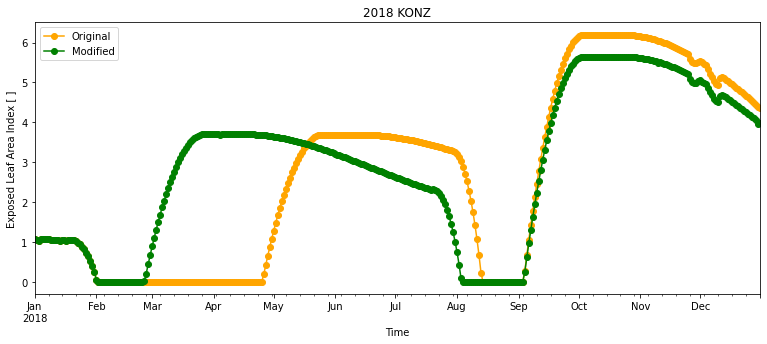

In [166]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = "sim_ELAI_orig" , marker = 'o' ,ax =ax , color = 'orange',label="Original")
df_daily.plot ( x= 'time', y = "sim_ELAI_mod" , marker = 'o' ,ax =ax , color = 'g',label="Modified")

plt.xlabel('Time')
plt.ylabel("Exposed Leaf Area Index [ ]")
plt.title(year+" "+neon_site)
plt.show()

In [167]:
### 4.4 : Create Scatter Plots:

In [173]:
var='TSOI'
tsoi = ds_ctsm_orig[var].isel(levgrnd=(slice(0,9)))
x= tsoi.time.values
y= -tsoi.levgrnd.values
plot_var =  tsoi[:,:,0].values.transpose()
plot_var = plot_var-273.15
        
cmap = 'YlOrRd'
var_name = 'Soil Temperature'
var_unit = '[\u00B0C]'


        

Text(0, 0.5, 'Soil Temperature [°C]')

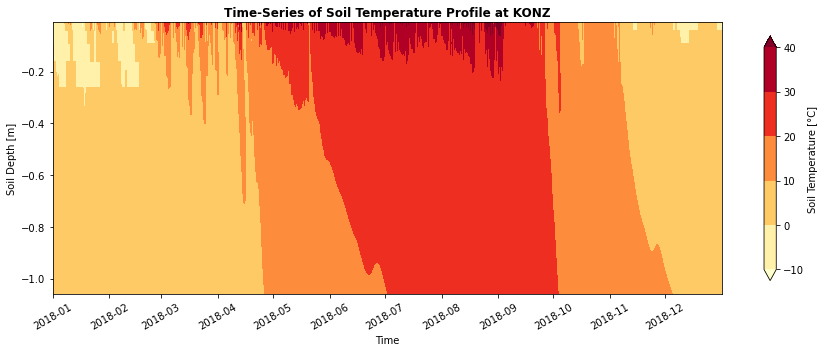

In [174]:
    X, Y = np.meshgrid(x, y)
    fig= plt.figure(num=None, figsize=(15,5),  facecolor='w', edgecolor='k')

    ax = plt.gca()
    cs = ax.contourf(X, Y, plot_var,cmap=cmap,extend="both")
    plt.xticks(rotation=30)
    plt.ylabel('Soil Depth [m]')
    plt.xlabel('Time')
    plt.title ('Time-Series of '+ var_name +' Profile at '+neon_site,fontweight="bold")
    cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
    y_label = var_name +' '+var_unit
    cbar.ax.set_ylabel(y_label)